**important note:** This notebook or kernel is inspired by  another original notebook by the Will Koehrsen, it is an excellent article, only it had few code cells error messages so I rewrote it to clear those errors and some little tweaks.

So if you learn something here , all the credit should go to him and not me and the original notebook is [here](https://www.kaggle.com/willkoehrsen/automated-feature-engineering-tutorial/data)

## Introduction: Automated Feature Engineering

In this notebook, we will look at an exciting development in data science: automated feature engineering. A machine learning model can only learn from the data we give it, and making sure that data is relevant to the task is one of the most crucial steps in the machine learning pipeline (this is made clear in the excellent paper [A Few Useful Things to Know about Machine Learning)](https://homes.cs.washington.edu/~pedrod/papers/cacm12.pdf).

However, manual feature engineering is a tedious task and is limited by both human imagination - there are only so many features we can think to create - and by time - creating new features is time-intensive. Ideally, there would be an objective method to create an array of diverse new candidate features that we can then use for a machine learning task. This process is meant to not replace the data scientist, but to make her/ his job easier and allowing her/his to supplement domain knowledge with an automated workflow.

In this notebook, we will walk through an implementation of using [**Feature Tools**](https://www.featuretools.com/), an open-source Python library for automatically creating features with relational data (where the data is in structured tables). Although there are now many efforts working to enable automated model selection and hyperparameter tuning, there has been a lack of automating work on the feature engineering aspect of the pipeline. This library seeks to close that gap and the general methodology has been proven effective in both machine learning competitions and business use cases.

## Dataset

To show the basic idea of feature tools we will use an example dataset consisting of three tables:

- `clients`: information about clients at a credit union
- `loans`: previous loans taken out by the clients
- `payments`: payments made/missed on the previous loans


The general problem of feature engineering is taking disparate data, often distributed across multiple tables, and combining it into a single table that can be used for training a machine learning model. Feature tools has the ability to do this for us, creating many new candidate features with minimal effort. These features are combined into a single table that can then be passed on to our model.

First we need to install the **featuretools** library using pip or conda as usual before we can use it.See [here](https://docs.featuretools.com/getting_started/install.html) for installation instructions

First, let's load in the data and look at the problem we are working with.

In [1]:
# pandas and numpy for data manipulation
import pandas as pd
import numpy as np

# featuretools for automated feature engineering
import featuretools as ft

# ignore warnings from pandas
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Read in the data
clients = pd.read_csv('./data/clients.csv', parse_dates = ['joined'])
loans = pd.read_csv('./data/loans.csv', parse_dates = ['loan_start', 'loan_end'])
payments = pd.read_csv('./data/payments.csv', parse_dates = ['payment_date'])

In [3]:
clients.head()

,client_id,joined,income,credit_score
0,46109,2002-04-16,172677,527
1,49545,2007-11-14,104564,770
2,41480,2013-03-11,122607,585
3,46180,2001-11-06,43851,562
4,25707,2006-10-06,211422,621


In [4]:
loans.sample(10)

,client_id,loan_type,loan_amount,repaid,loan_id,loan_start,loan_end,rate
252,29841,home,14703,0,10116,2013-04-01,2015-05-15,1.19
235,32961,credit,12553,1,11113,2001-09-08,2003-06-15,2.98
161,35214,cash,13309,0,11023,2007-06-09,2009-11-21,2.66
60,46180,home,3022,0,11204,2003-11-22,2005-05-18,8.39
203,26326,other,10261,1,11386,2013-05-17,2015-10-07,0.74
424,49624,home,7876,1,11977,2005-05-15,2007-05-04,5.83
303,49068,cash,6473,1,11546,2002-09-01,2004-10-23,5.18
389,46958,credit,8308,0,10195,2014-08-12,2017-05-07,0.32
97,25707,cash,5467,0,10244,2006-12-28,2008-08-05,1.58
114,39505,credit,2778,1,10921,2012-10-23,2015-03-31,2.23


In [5]:
payments.sample(10)

,loan_id,payment_amount,payment_date,missed
881,11031,916,2009-08-30,0
1662,10769,210,2012-01-28,1
2054,10732,981,2003-07-28,0
1215,11010,749,2004-08-23,1
2745,11959,884,2004-01-17,0
2961,10195,1659,2015-02-05,0
2583,11798,243,2013-12-30,1
1671,10271,76,2013-07-28,1
1236,10741,748,2002-06-15,0
3061,10697,1720,2012-03-13,1


### Feature Tools

Now what we want is a combined  single table with all the most useful features for each client from these three tables and  trying to avoid (tedious manual feature engineering), let's figure out how to automate this process. Feature tools operates on an idea known as **Deep Feature Synthesis**. You can read the original paper [here](http://www.jmaxkanter.com/static/papers/DSAA_DSM_2015.pdf), and although it's quite readable, it's not necessary to understand the details to do automated feature engineering. The concept of Deep Feature Synthesis is to use basic building blocks known as feature primitives (like the transformations and aggregations ) that can be stacked on top of each other to form new features. The depth of a "deep feature" is equal to the number of stacked primitives.

Lot of new terms popped up here, but don't worry because we'll cover them as we go. Feature Tools builds on simple ideas to create a powerful method, and we will build up our understanding in much the same way.

The first part of Feature Tools to understand is an entity. This is simply a table, or in pandas, a DataFrame. We combine multiple entities into a single object called an EntitySet. This is just a large data structure composed of many individual entities and the relationships between them.

### EntitySet

Creating a new EntitySet is pretty simple:

In [6]:
es = ft.EntitySet(id = 'clients')

In [7]:
es


Entityset: clients
  Entities:
  Relationships:
    No relationships

### Entities

An entity is simply a table, which is represented in Pandas as a `dataframe`. Each entity must have a uniquely identifying column, known as an index. For the clients dataframe, this is the `client_id` because each id only appears once in the clients data. In the loans dataframe, `client_id` is not an index because each id might appear more than once. The index for this dataframe is instead `loan_id`.

When we create an entity in feature tools, we have to identify which column of the dataframe is the index. If the data does not have a unique index we can tell feature tools to make an index for the entity by passing in `make_index = True` and specifying a name for the index. If the data also has a uniquely identifying time index, we can pass that in as the `time_index` parameter.

Feature tools will automatically infer the variable types (numeric, categorical, datetime) of the columns in our data, but we can also pass in specific datatypes to override this behavior. As an example, even though the `repaid` column in the loans dataframe is represented as an integer, we can tell feature tools that this is a categorical feature since it can only take on two discrete values. This is done using an `variable_type`dict parameter with the variables as keys and the feature types as values.

In the code below we create the three entities and add them to the EntitySet. The syntax is relatively straightforward with a few notes: for the payments dataframe we need to make an index, for the loans dataframe, we specify that repaid is a categorical variable, and for the payments dataframe, we specify that missed is a categorical feature

In [8]:
# Create an entity from the client dataframe
# This dataframe already has an index and a time index
es = es.entity_from_dataframe(entity_id = 'clients', dataframe = clients, 
                              index = 'client_id', time_index = 'joined')

In [9]:
es


Entityset: clients
  Entities:
    clients [Rows: 25, Columns: 4]
  Relationships:
    No relationships

In [10]:
# Create an entity from the loans dataframe
# This dataframe already has an index and a time index
es = es.entity_from_dataframe(entity_id = 'loans', dataframe = loans, 
                              variable_types = {'repaid': ft.variable_types.Categorical},
                              index = 'loan_id', 
                              time_index = 'loan_start')

In [11]:
# Create an entity from the payments dataframe
# This does not yet have a unique index
es = es.entity_from_dataframe(entity_id = 'payments', 
                              dataframe = payments,
                              variable_types = {'missed': ft.variable_types.Categorical},
                              make_index = True,
                              index = 'payment_id',
                              time_index = 'payment_date')

In [12]:
es

Entityset: clients
  Entities:
    clients [Rows: 25, Columns: 4]
    loans [Rows: 443, Columns: 8]
    payments [Rows: 3456, Columns: 5]
  Relationships:
    No relationships

All three entities have been successfully added to the `EntitySet`. We can access any of the entities using Python dictionary syntax.

In [13]:
es['loans']

Entity: loans
  Variables:
    loan_id (dtype: index)
    client_id (dtype: numeric)
    loan_type (dtype: categorical)
    loan_amount (dtype: numeric)
    loan_start (dtype: datetime_time_index)
    loan_end (dtype: datetime)
    rate (dtype: numeric)
    repaid (dtype: categorical)
  Shape:
    (Rows: 443, Columns: 8)

Feature tools correctly inferred each of the datatypes when we made this entity. We can also see that we overrode the type for the `repaid` feature, changing if from numeric to categorical.

In [14]:
es['payments']

Entity: payments
  Variables:
    payment_id (dtype: index)
    loan_id (dtype: numeric)
    payment_amount (dtype: numeric)
    payment_date (dtype: datetime_time_index)
    missed (dtype: categorical)
  Shape:
    (Rows: 3456, Columns: 5)

### Relationships

After defining the entities (tables) in an `EntitySet`, we now need to tell feature tools how they are related with a relationship. The most intuitive way to think of relationships is with the parent to child analogy: a parent-to-child relationship is one-to-many because for each parent, there can be multiple children. The `client` dataframe is therefore the parent of the `loans` dataframe because while there is only one row for each client in the client dataframe, each client may have several previous loans covering multiple rows in the loans dataframe. Likewise, the loans dataframe is the parent of the `payments` dataframe because each loan will have multiple payments.

These relationships are what allow us to group together datapoints using aggregation primitives and then create new features. As an example, we can group all of the previous loans associated with one client and find the average loan amount. We will discuss the features themselves more in a little bit, but for now let's define the relationships.

To define relationships, we need to specify the parent variable and the child variable. This is the variable that links two entities together. In our example, the client and loans dataframes are linked together by the `client_id` column. Again, this is a parent to child relationship because for each `client_id` in the parent client dataframe, there may be multiple entries of the same `client_id` in the child loans dataframe.

We codify relationships in the language of feature tools by specifying the parent variable and then the child variable. After creating a relationship, we add it to the EntitySet.

In [15]:
# Relationship between clients and previous loans
r_client_previous = ft.Relationship(es['clients']['client_id'],
                                    es['loans']['client_id'])

# Add the relationship to the entity set
es = es.add_relationship(r_client_previous)

The relationship has now been stored in the entity set. The second relationship is between the `loans` and `payments`. These two entities are related by the `loan_id` variable.

In [16]:
# Relationship between previous loans and previous payments
r_payments = ft.Relationship(es['loans']['loan_id'],
                                      es['payments']['loan_id'])

# Add the relationship to the entity set
es = es.add_relationship(r_payments)

es

Entityset: clients
  Entities:
    clients [Rows: 25, Columns: 4]
    loans [Rows: 443, Columns: 8]
    payments [Rows: 3456, Columns: 5]
  Relationships:
    loans.client_id -> clients.client_id
    payments.loan_id -> loans.loan_id

We now have our entities in an entityset along with the relationships between them. We can now start to making new features from all of the tables using stacks of feature primitives to form deep features. First, let's cover feature primitives.

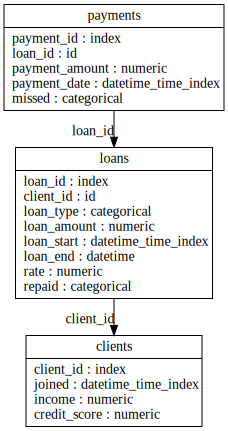

In [17]:
es.plot()

### Feature Primitives

A feature primitive is at a very high-level is an operation applied to data to create a feature. These represent very simple calculations that can be stacked on top of each other to create complex features. Feature primitives fall into two categories:

- **Aggregation:** function that groups together child datapoints for each parent and then calculates a statistic such as mean, min, max, or standard deviation. An example is calculating the maximum loan amount for each client. An aggregation works across multiple tables using relationships between tables.


- **Transformation:** an operation applied to one or more columns in a single table. An example would be extracting the day from dates, or finding the difference between two columns in one table.

Let's take a look at feature primitives in feature tools.

We can view the list of primitives:

In [18]:
primitives = ft.list_primitives()
pd.options.display.max_colwidth = 100
primitives[primitives['type'] == 'aggregation']

,name,type,description
0,time_since_last,aggregation,Calculates the time elapsed since the last datetime (default in seconds).
1,count,aggregation,"Determines the total number of values, excluding `NaN`."
2,mean,aggregation,Computes the average for a list of values.
3,last,aggregation,Determines the last value in a list.
4,any,aggregation,Determines if any value is 'True' in a list.
5,avg_time_between,aggregation,Computes the average number of seconds between consecutive events.
6,time_since_first,aggregation,Calculates the time elapsed since the first datetime (in seconds).
7,skew,aggregation,Computes the extent to which a distribution differs from a normal distribution.
8,n_most_common,aggregation,Determines the `n` most common elements.
9,median,aggregation,Determines the middlemost number in a list of values.


In [19]:
primitives[primitives['type'] == 'transform']

,name,type,description
20,latitude,transform,Returns the first tuple value in a list of LatLong tuples.
21,cum_count,transform,Calculates the cumulative count.
22,multiply_numeric_scalar,transform,Multiply each element in the list by a scalar.
23,modulo_numeric_scalar,transform,Return the modulo of each element in the list by a scalar.
24,and,transform,Element-wise logical AND of two lists.
25,cum_min,transform,Calculates the cumulative minimum.
26,scalar_subtract_numeric_feature,transform,Subtract each value in the list from a given scalar.
27,less_than,transform,Determines if values in one list are less than another list.
28,second,transform,Determines the seconds value of a datetime.
29,divide_by_feature,transform,Divide a scalar by each value in the list.


If feature tools does not have enough primitives for us, we can also make our own.

To get an idea of what a feature primitive actually does, let's try out a few on our data. Using primitives is surprisingly easy using the `ft.dfs` function (which stands for deep feature synthesis). In this function, we specify the `entityset` to use; the target_entity, which is the dataframe we want to make the features for (where the features end up); the `agg_primitives` which are the aggregation feature primitives; and the `trans_primitives` which are the transformation primitives to apply.

In the following example, we are using the EntitySet we already created, the target entity is the clients dataframe because we want to make new features about each client, and then we specify a few aggregation and transformation primitives.

In [20]:
# Create new features using specified primitives
features, feature_names = ft.dfs(entityset = es, target_entity = 'clients', 
                                 agg_primitives = ['mean', 'max', 'percent_true', 'last'],
                                 trans_primitives = ['year', 'month', 'divide_by_feature'])

In [21]:
features

,income,credit_score,MEAN(loans.loan_amount),MEAN(loans.rate),MAX(loans.loan_amount),MAX(loans.rate),LAST(loans.loan_type),LAST(loans.loan_amount),LAST(loans.rate),LAST(loans.repaid),...,MONTH(LAST(payments.payment_date)),1 / MEAN(loans.loan_amount),1 / MEAN(loans.rate),1 / MAX(loans.loan_amount),1 / MAX(loans.rate),1 / LAST(loans.loan_amount),1 / LAST(loans.rate),1 / MEAN(payments.payment_amount),1 / MAX(payments.payment_amount),1 / LAST(payments.payment_amount)
client_id,,,,,,,,,,,,,,,,,,,,,
25707,211422,621,7963.950000,3.477000,13913,9.44,home,2203,7.40,0,...,11,0.000126,0.287604,0.000072,0.105932,0.000454,0.135135,0.000848,0.000370,0.004149
26326,227920,633,7270.062500,2.517500,13464,6.73,credit,5275,1.45,0,...,8,0.000138,0.397219,0.000074,0.148588,0.000190,0.689655,0.000857,0.000376,0.001073
26695,174532,680,7824.722222,2.466111,14865,6.51,other,13918,0.90,1,...,3,0.000128,0.405497,0.000067,0.153610,0.000072,1.111111,0.000828,0.000341,0.000480
26945,214516,806,7125.933333,2.855333,14593,5.65,cash,9249,2.86,1,...,7,0.000140,0.350222,0.000069,0.176991,0.000108,0.349650,0.000901,0.000361,0.000626
29841,38354,523,9813.000000,3.445000,14837,6.76,home,7223,5.09,1,...,1,0.000102,0.290276,0.000067,0.147929,0.000138,0.196464,0.000695,0.000345,0.001250
32726,235705,730,6633.263158,3.058947,14802,9.10,other,5325,2.83,1,...,12,0.000151,0.326910,0.000068,0.109890,0.000188,0.353357,0.001059,0.000371,0.000987
32885,58955,642,9920.400000,2.436000,14162,9.11,other,11886,9.11,0,...,12,0.000101,0.410509,0.000071,0.109769,0.000084,0.109769,0.000716,0.000413,0.000524
32961,230341,714,7882.235294,3.930588,14784,9.14,cash,1693,1.46,1,...,10,0.000127,0.254415,0.000068,0.109409,0.000591,0.684932,0.000962,0.000358,0.004484
35089,131176,771,6939.200000,3.513500,13194,7.63,other,773,7.63,1,...,4,0.000144,0.284616,0.000076,0.131062,0.001294,0.131062,0.000913,0.000390,0.009434


In [22]:
feature_names

[<Feature: income>,
 <Feature: credit_score>,
 <Feature: MEAN(loans.loan_amount)>,
 <Feature: MEAN(loans.rate)>,
 <Feature: MAX(loans.loan_amount)>,
 <Feature: MAX(loans.rate)>,
 <Feature: LAST(loans.loan_type)>,
 <Feature: LAST(loans.loan_amount)>,
 <Feature: LAST(loans.rate)>,
 <Feature: LAST(loans.repaid)>,
 <Feature: MEAN(payments.payment_amount)>,
 <Feature: MAX(payments.payment_amount)>,
 <Feature: LAST(payments.payment_amount)>,
 <Feature: LAST(payments.missed)>,
 <Feature: YEAR(joined)>,
 <Feature: MONTH(joined)>,
 <Feature: 1 / income>,
 <Feature: 1 / credit_score>,
 <Feature: MEAN(loans.MEAN(payments.payment_amount))>,
 <Feature: MEAN(loans.MAX(payments.payment_amount))>,
 <Feature: MEAN(loans.LAST(payments.payment_amount))>,
 <Feature: MEAN(loans.1 / loan_amount)>,
 <Feature: MEAN(loans.1 / rate)>,
 <Feature: MAX(loans.MEAN(payments.payment_amount))>,
 <Feature: MAX(loans.LAST(payments.payment_amount))>,
 <Feature: MAX(loans.1 / loan_amount)>,
 <Feature: MAX(loans.1 / rate)>

Already we can see how useful feature tools is, and Examining the names of the features in the dataframe brings us to the final piece of the puzzle: deep features.

### Deep Feature Synthesis

While feature primitives are useful by themselves, the main benefit of using feature tools arises when we stack primitives to get deep features. The depth of a feature is simply the number of primitives required to make a feature. So, a feature that relies on a single aggregation would be a deep feature with a depth of 1, a feature that stacks two primitives would have a depth of 2 and so on. The idea itself is lot simpler than the name "deep feature synthesis" implies. (I think the authors were trying to ride the way of deep neural network hype when they named the method!) To read more about deep feature synthesis, check out the [documentation](https://docs.featuretools.com/automated_feature_engineering/afe.html) or the original [paper by Max Kanter et al](http://www.jmaxkanter.com/static/papers/DSAA_DSM_2015.pdf).

Already in the dataframe we made by specifying the primitives manually we can see the idea of feature depth. For instance, the `MEAN(loans.loan_amount)` feature has a depth of 1 because it is made by applying a single aggregation primitive. This feature represents the average size of a client's previous loans.

In [23]:
# Show a feature with a depth of 1
pd.DataFrame(features['MEAN(loans.loan_amount)'].head(10))

,MEAN(loans.loan_amount)
client_id,
25707,7963.950000
26326,7270.062500
26695,7824.722222
26945,7125.933333
29841,9813.000000
32726,6633.263158
32885,9920.400000
32961,7882.235294
35089,6939.200000


As well scroll through the features, we see a number of features with a depth of 2. For example, the `LAST(loans.(MEAN(payments.payment_amount)))` has depth = 2 because it is made by stacking two feature primitives, first an aggregation and then a transformation. This feature represents the average payment amount for the last (most recent) loan for each client.

In [24]:
# Show a feature with a depth of 2
pd.DataFrame(features['LAST(loans.MEAN(payments.payment_amount))'].head(10))

,LAST(loans.MEAN(payments.payment_amount))
client_id,
25707,293.500000
26326,977.375000
26695,1769.166667
26945,1598.666667
29841,1125.500000
32726,799.500000
32885,1729.000000
32961,282.600000
35089,110.400000


We can create features of arbitrary depth by stacking more primitives. However, usually we never go beyond a depth of 2! After this point, the features become very convoluted to understand. I'd encourage anyone interested to experiment with increasing the depth (maybe for a real problem) and see if there is value to "going deeper".

### Automated Deep Feature Synthesis

In addition to manually specifying aggregation and transformation feature primitives, we can let feature tools automatically generate many new features. We do this by making the same ft.dfs function call, but without passing in any primitives. We just set the max_depth parameter and feature tools will automatically try many all combinations of feature primitives to the ordered depth.

When running on large datasets, this process can take quite a while, but for our example data, it will be relatively quick. For this call, we only need to specify the  entityset, the target_entity (which will again be clients), and the  max_depth.

In [25]:
# Perform deep feature synthesis without specifying primitives
features, feature_names = ft.dfs(entityset=es, target_entity='clients', 
                                 max_depth = 2)

In [26]:
features.iloc[:, 2:].head()

,SUM(loans.loan_amount),SUM(loans.rate),STD(loans.loan_amount),STD(loans.rate),MAX(loans.loan_amount),MAX(loans.rate),SKEW(loans.loan_amount),SKEW(loans.rate),MIN(loans.loan_amount),MIN(loans.rate),...,NUM_UNIQUE(loans.WEEKDAY(loan_end)),MODE(loans.MODE(payments.missed)),MODE(loans.DAY(loan_start)),MODE(loans.DAY(loan_end)),MODE(loans.YEAR(loan_start)),MODE(loans.YEAR(loan_end)),MODE(loans.MONTH(loan_start)),MODE(loans.MONTH(loan_end)),MODE(loans.WEEKDAY(loan_start)),MODE(loans.WEEKDAY(loan_end))
client_id,,,,,,,,,,,,,,,,,,,,,
25707,159279,69.54,4149.486062,2.484186,13913,9.44,-0.186352,0.735470,1212,0.33,...,6,0,27,1,2010,2007,1,8,3,0
26326,116321,40.28,4393.666631,2.057142,13464,6.73,0.149658,1.181651,1164,0.50,...,5,0,6,6,2003,2005,4,7,5,2
26695,140845,44.39,4196.462499,1.561659,14865,6.51,0.168879,0.896574,2389,0.22,...,6,0,3,14,2003,2005,9,4,1,1
26945,106889,42.83,4543.621769,1.619717,14593,5.65,0.174492,-0.002227,653,0.13,...,6,0,16,1,2002,2004,12,5,0,1
29841,176634,62.01,4209.224171,2.122904,14837,6.76,-0.232215,0.055321,2778,0.26,...,7,1,1,15,2005,2007,3,2,5,1


Deep feature synthesis has created 90 new features out of the existing data! While we could have created all of these manually,Thank God! not have to write all that code by hand. The primary benefit of feature tools is that it creates features without any subjective human biases. Even a human with considerable domain knowledge will be limited by their imagination when making new features (not to mention time). Automated feature engineering is not limited by these factors (instead it's limited by computation time) and provides a good starting point for feature creation. This process likely will not remove the human contribution to feature engineering completely because a human can still use domain knowledge and machine learning expertise to select the most important features or build new features from those suggested by automated deep feature synthesis.

### Next Steps

While automatic feature engineering solves one problem, it provides us with another problem: too many features! Although it's difficult to say which features will be important to a given machine learning task ahead of time, it's likely that not all of the features made by feature tools add value. In fact, having too many features is a significant issue in machine learning because it makes training a model much harder. The irrelevant features can drown out the important features, leaving a model unable to learn how to map the features to the target.

This problem is known as the "curse of dimensionality" and is addressed through the process of **feature reduction(a.k.a Dimension Reductionality) and feature selection**, which means removing low-value features from the data. Defining which features are useful is an important problem where a data scientist can still add considerable value to the feature engineering task.

I have few notebooks on my github [ML-tutorials repo](https://github.com/KVSSetty/ML-Tutorials) for some details on dimensionality reduction and feature selection 

### Conclusions

In this notebook, we saw how to apply automated feature engineering to an example dataset. This is a powerful method which allows us to overcome the human limits of time and imagination to create many new features from multiple tables of data. Feature tools is built on the idea of deep feature synthesis, which means stacking multiple simple feature primitives - **aggregations and transformations** - to create new features. Feature engineering allows us to combine information across many tables into a single dataframe that we can then use for machine learning model training. Finally, the next step after creating all of these features is figuring out which ones are important.

Feature tools is currently the only Python option for this process, but with the recent emphasis on automating aspects of the machine learning pipeline, other competitiors will probably enter the sphere. While the exact tools will change, the idea of automatically creating new features out of existing data will grow in importance. Staying up-to-date on methods such as automated feature engineering is crucial in the rapidly changing field of data science. Now go out there and find a problem on which to apply feature tools!

For more information, check out the [documentation](https://docs.featuretools.com/) for feature tools. Also, read about how feature tools is used in the real world by [Feature Labs, the company behind the open-source library.](https://www.featuretools.com/)